In [1]:
!pip install geopandas
!pip install folium
!pip install shapely
!pip install numpy
!pip install catboost
!pip install matplotlib
!pip install geopandas
!pip install pandas
!pip install networkx
!pip install plotly
!pip install scikit-learn

In [2]:
import geopandas as gpd
import warnings
import folium
from shapely.geometry import mapping
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

## Первичная предобработка данных и визуализация
Импорт исходного датасета в формате gpd. Основное отличие GeoDataFrame - наличие специального столбца 'geometry', который содержит геометрические объекты, такие как точки, линии и полигоны. Это позволяет представлять сложные географические структуры в табличном формате, сохраняя при этом их пространственные характеристики.

In [3]:
# Игнорирование предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning)

# Чтение shapefile для станций
shapefile_stations_path = "/kaggle/input/rzhd-hack/stationsv2.shp"
shapefile_stations = gpd.read_file(shapefile_stations_path)

shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")

# Выделение координат в отдельные столбцы для станций
shapefile_stations['longitude'] = shapefile_stations.geometry.x
shapefile_stations['latitude'] = shapefile_stations.geometry.y

In [4]:
# Инициализация карты Folium, центрируем карту на среднем значении координат станций
m = folium.Map(location=[shapefile_stations['latitude'].mean(), shapefile_stations['longitude'].mean()], zoom_start=5, tiles='OpenStreetMap')

# Добавление точек станций на карту
for idx, row in shapefile_stations.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
    ).add_to(m)

# Сохранение карты в HTML
m.save("stations_map.html")

# Вывод карты
m

In [5]:
shapefile2['maxspeed'].unique()

array([None, '100', '40', "['80', '100']", '80', '70', '120',
       "['120', '100']", "['90', '100']", "['140', '120', '100']",
       "['140', '120']", "['70', '100']", "['40', '100']", '90',
       "['90', '60']", "['80', '90']", "['40', '80', '100']",
       "['80', '120']", '140', "['90', '40', '60']",
       "['140', '120', '115', '100']", "['120', '90']",
       "['120', '80', '100']", "['120', '100', '140', '95', '110']",
       "['120', '100', '130', '95', '110']",
       "['120', '100', '80', '140', '90']", "['140', '100']",
       "['95', '100']", '110', "['80', '70']", "['140', '80']",
       "['140', '80', '120']", "['110', '120', '130', '100']", '25',
       "['120', '60']", '60', "['120', '70']", "['85', '110']",
       "['95', '90', '120', '100']", "['120', '80', '85', '95', '90']",
       "['80', '120', '100']", "['140', '120', '80']",
       "['120', '80', '160']", "['120', '110']", "['140', '115', '100']",
       "['90', '115']", "['130', '100']", "['120', '130', '10

In [6]:
shapefile2['maxspeed'].fillna(80, inplace=True)

for i, a in enumerate(shapefile2['maxspeed']):
    if type(a) is str:
        if a[0] == '[':
            shapefile2['maxspeed'].iloc[i] = a.strip('][').split(", ")
            shapefile2['maxspeed'].iloc[i] = [int(j.strip("''")) for j in shapefile2['maxspeed'].iloc[i]]
            shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in shapefile2['maxspeed'].iloc[i]]) / len(shapefile2['maxspeed'].iloc[i])
        else:
            shapefile2['maxspeed'].iloc[i] = int(shapefile2['maxspeed'].iloc[i])
    elif type(a) is list:
        shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in a]) / len(a)

In [7]:
shapefile2['maxspeed'].value_counts()

maxspeed
80            20519
100            1723
120            1583
40             1373
110.0           335
140             270
60              270
90.0            262
70              179
130.0           170
95.0             57
85.0             39
115.0            37
113.333333       27
105.0            22
160              21
75.0             13
50               11
170.0            10
116.666667       10
97.5              9
180               7
117.5             7
103.75            6
93.333333         6
106.875           6
121.666667        6
133.333333        6
123.333333        6
122.5             6
63.333333         6
102.5             5
118.333333        5
200               5
105.833333        4
103.333333        4
25                4
106.0             4
150.0             3
112.5             2
73.333333         2
125.0             2
94.0              2
111.0             2
83.333333         2
101.25            2
152.5             2
113.0             1
118.75            1
111.666667 

Большое количество пустых значений получили для maxspeed. Посмотрев, что 90 - максимальная разрешенная скорость для товарных поездов по дефолту взяли 80, так как на валидационной выборке большинство результатов было сильно занижено.

Это привело к увеличению целевой метрики на 2%.

In [8]:
# Удаляем лишний столбец
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

# Объединение негеометрических столбцов путем группировки и применения unary_union
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).agg({'length': 'sum', 'maxspeed': 'mean'}).reset_index()
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Преобразуем в формат GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

print(aggregated_data)

                    origin                     destinatio         length  \
0       Александро-Невская                         Рыбное  366205.310940   
1   Бекасово-Сортировочное                        Вековка  582400.951675   
2   Бекасово-Сортировочное          Люблино-Сортировочное  152592.604138   
3   Бекасово-Сортировочное                  Малоярославец   90812.379613   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  102367.038251   
..                     ...                            ...            ...   
75                   Унеча                       Стародуб   72839.885639   
76                 Фрязево                        Ногинск   31451.733248   
77                 Щёлково               Лосиноостровская   63559.332180   
78       Ярославль-Главный               Лосиноостровская  379289.772135   
79       Ярославль-Главный                  Орехово-Зуево  446382.194123   

     maxspeed                                           geometry  
0        80.0  MULTI

Отдельные графики точек и путей

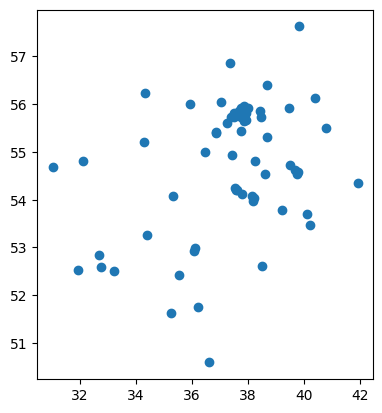

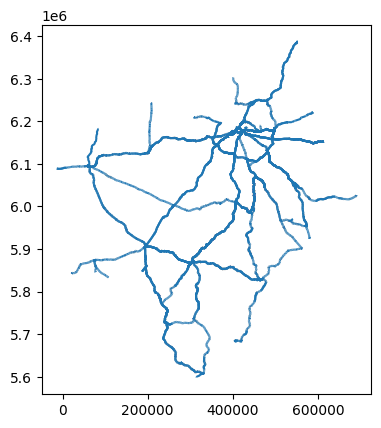

In [9]:
# График станций
shape2 = aggregated_data
shapefile_stations.plot()
plt.show()

# График путей
shape2.plot()
plt.show()


In [10]:
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

print(aggregated_data[['origin','destinatio','geometry', 'length_km', "maxspeed"]])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km   maxspeed  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385       80.0  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  81.370158  
2   MULTILINESTRING ((420474.2

Импорт тренировочного датасета, который состоит из времени поезда в пути и пунктов прибытия и отбытия.

In [11]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


Создание графа.

In [12]:
all_routes = aggregated_data


# Граф для расстояний (кратчайшее по расстоянию)
G = nx.Graph()

# Добавляем узлы в виде станций
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Добавляем ребра в виде расстояний между пунктами
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # У нас есть переменная reversed, которая должна сделать граф ориентированным
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])
    
# Граф для времени (самый быстрый по времени)
F = nx.Graph()

# Добавляем узлы в виде станций
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
F.add_nodes_from(stations)

# Добавляем ребра в виде времени между пунктами
for index, row in all_routes.iterrows():
    F.add_edge(row['origin'], row['destinatio'], weight=row['length_km']/row['maxspeed'])
    # У нас есть переменная reversed, которая должна сделать граф ориентированным
    F.add_edge(row['destinatio'], row['origin'], weight=row['length_km']/row['maxspeed'])


Вручную добавляем ребра к пунктам, у которых нет маршрутов в all_routes

In [13]:
missing_routes=pd.DataFrame([['Аэропорт','Москва-Сортировочная-Киевская',30],
                             ['Аэропорт','Кунцево II',26.7],
                             ['Аэропорт','Москва-Товарная-Смоленская',38],
                             ['Бекасово-Центральное','Бекасово-Сортировочное',1.9],
                             ['Бекасово-Центральное','Малоярославец',60],
                             ['Бекасово-Центральное','Аэропорт',40],
                             ['Брянск-Орловский','Сухиничи-Главные',140],
                             ['Брянск-Орловский','Лужки-Орловские',133],
                             ['Брянск-Орловский','Смоленск-Сортировочный',400],
                             ['Домодедово','Ожерелье',90],
                             ['Домодедово','Узуново',130],
                             ['Домодедово','Фрязево',100],
                             ['Люберцы II','Перово',25.4],
                             ['Люберцы II','Яничкино',10],
                             ['Люберцы II','Поварово-3',93],
                             ['Павелец-Тульский','Узуново',120],
                             ['Павелец-Тульский','Узловая-I',90],
                             ['Павелец-Тульский','Ряжск I',75],
                             ['Перово','Кусково',2],
                             ['Перово','Ряжск I',320],
                             ['Перово','Балашиха',15],
                             ['Стенькино-II','Рыбное',39],
                             ['Стенькино-II','Ряжск I',110],
                             ['Стенькино-II','Сасово',200],
                             ['Тула-Вяземская','Присады',20],
                             ['Тула-Вяземская','Серпухов',100],
                             ['Тула-Вяземская','Елец',220],
                             ['Присады','Узловая-I',40],
                             ['Присады','Павелец-Тульский',130],
                             ['Присады','Серпухов',120],
                             ['Александров-1','Зелёный бор',100],
                             ['Александров-1','Петушки',90],
                             ['Александров-1','Поварово-3',145],
                             ['Савёлово','Подмосковная',170],
                             ['Савёлово','Домодедово',200],
                             ['Савёлово','Поварово-3',130],
                            ])
missing_routes
#Добавляем все в графы
for index, row in missing_routes.iterrows():
    G.add_edge(row[0], row[1], weight=row[2])
    G.add_edge(row[1], row[0], weight=row[2])
    
for index, row in missing_routes.iterrows():
    F.add_edge(row[0], row[1], weight=row[2]/80)
    F.add_edge(row[1], row[0], weight=row[2]/80)

In [14]:
def draw_graph(graph, title):
    pos = nx.spring_layout(graph)  # Расположение узлов с использованием spring layout

    # Получаем координаты узлов
    x_nodes = [pos[node][0] for node in graph.nodes()]
    y_nodes = [pos[node][1] for node in graph.nodes()]

    # Создаем рёбра
    edge_x = []
    edge_y = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Создаем фигуру для узлов и рёбер
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        mode='lines')

    node_trace = go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers+text',
        hoverinfo='text',
        text=[f'{node}<br>degree: {degree}' for node, degree in graph.degree()],
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            color=list(nx.degree_centrality(graph).values()),
            colorbar=dict(
                thickness=15,
                title='Node Degree',
                xanchor='left',
                titleside='right'
            ),
        ),
        textposition='top center'
    )

    # Создаем структуру графа
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="Railway Graph Visualization",
                            showarrow=False,
                            xref="paper", yref="paper"
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

In [15]:
# Визуализация графов
draw_graph(G, 'Graph G - Расстояния')

In [16]:
draw_graph(F, 'Graph F - Время')

In [17]:
# Функция поиска кратчайшего пути между начальной и конечной станциями
def find_shortest_path(start_station, end_station):
    try:
        if not (start_station in G and end_station in G):
            return 0, 0, 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            # Расчет расстояний между соседними станциями
            distances_between_stations = []
            for i in range(len(shortest_path) - 1):
                distances_between_stations.append(G[shortest_path[i]][shortest_path[i + 1]]['weight'])
            return shortest_path, shortest_distance, num_stations, min(distances_between_stations), max(distances_between_stations)
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf'), float('inf'), float('inf'), 

# Функция для поиска самого быстрого пути
def find_fastest_path(start_station, end_station):
    try:
        if not (start_station in F and end_station in F):
            return 0, 0, 0, 0, 0
        else:
            fastest_path = nx.dijkstra_path(F, start_station, end_station, weight='weight')
            fastest_distance = nx.dijkstra_path_length(F, start_station, end_station, weight='weight')
            num_stations_fast = len(fastest_path) - 1
            # Расчет времени между соседними станциями
            times_between_stations = []
            for i in range(len(fastest_path) - 1):
                times_between_stations.append(F[fastest_path[i]][fastest_path[i + 1]]['weight'])
            return fastest_path, fastest_distance, num_stations_fast, min(times_between_stations), max(times_between_stations)
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf'), float('inf'), float('inf'), 

for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations, min_distances_between_stations,max_distances_between_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast, min_times_between_stations,max_times_between_stations = find_fastest_path(start_station, end_station)
    if shortest_path:
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
        train_df.at[index, 'min_distances_between_stations'] = min_distances_between_stations
        train_df.at[index, 'max_distances_between_stations'] = max_distances_between_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = 0 
        train_df.at[index, 'num_stations'] = 0
        train_df.at[index, 'min_distances_between_stations'] = 0
        train_df.at[index, 'max_distances_between_stations'] = 0
    if fastest_path:
        train_df.at[index, 'optimal_distance_hours'] = fastest_distance
        train_df.at[index, 'num_stations_fast'] = num_stations_fast
        train_df.at[index, 'min_times_between_stations'] = min_times_between_stations
        train_df.at[index, 'max_times_between_stations'] = max_times_between_stations
    else:
        train_df.at[index, 'optimal_distance_hours'] = 0
        train_df.at[index, 'num_stations_fast'] = 0
        train_df.at[index, 'min_times_between_stations'] = 0
        train_df.at[index, 'max_times_between_stations'] = 0




Загружаем тестовый датасет:

In [18]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [19]:
# Поиск кратчайших путей на графе и вывод новых фичей
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations, min_distances_between_stations,max_distances_between_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast, min_times_between_stations,max_times_between_stations = find_fastest_path(start_station, end_station)
    if shortest_path:
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
        test_df.at[index, 'min_distances_between_stations'] = min_distances_between_stations
        test_df.at[index, 'max_distances_between_stations'] = max_distances_between_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = 0
        test_df.at[index, 'num_stations'] = 0
        test_df.at[index, 'min_distances_between_stations'] = 0
        test_df.at[index, 'max_distances_between_stations'] = 0
    if fastest_path:

        test_df.at[index, 'optimal_distance_hours'] = fastest_distance
        test_df.at[index, 'num_stations_fast'] = num_stations_fast
        test_df.at[index, 'min_times_between_stations'] = min_times_between_stations
        test_df.at[index, 'max_times_between_stations'] = max_times_between_stations
    else:
        test_df.at[index, 'optimal_distance_hours'] = 0
        test_df.at[index, 'num_stations_fast'] = 0
        test_df.at[index, 'min_times_between_stations'] = 0
        test_df.at[index, 'max_times_between_stations'] = 0

print(test_df)


      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  min_distances_between_stations  \
0              757.835709           4.0                       37.363177   
1              441.045695           4.0      

## Построение предсказательной модели

In [20]:
X = train_df.drop(columns=["index",'value']) 
y = train_df['value']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=42)


In [21]:
train_pool = Pool(data=X_train, label=y_train, cat_features=['route_start', 'route_end'])
val_pool = Pool(data=X_val, label=y_val, cat_features=['route_start', 'route_end'])

catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.1,
    'depth': 6,
    "l2_leaf_reg": 3,
    "leaf_estimation_iterations": 10,
    'loss_function': "RMSE",
    'random_seed': 42
}
# Запускаем кросс-валидацию
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5, 
                verbose=100,
                plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 10.8498915	test: 10.9125447	best: 10.9125447 (0)	total: 59.9ms	remaining: 1m 29s
100:	learn: 1.2375178	test: 1.4222611	best: 1.4222611 (100)	total: 464ms	remaining: 6.42s
200:	learn: 0.8735517	test: 1.2890535	best: 1.2865501 (196)	total: 860ms	remaining: 5.55s
300:	learn: 0.6744515	test: 1.2723552	best: 1.2723552 (300)	total: 1.26s	remaining: 5.03s
400:	learn: 0.5333769	test: 1.2427012	best: 1.2427012 (400)	total: 1.65s	remaining: 4.52s
500:	learn: 0.4409253	test: 1.2180487	best: 1.2179623 (498)	total: 2.06s	remaining: 4.1s
600:	learn: 0.3570657	test: 1.2146737	best: 1.2135006 (593)	total: 2.47s	remaining: 3.69s
700:	learn: 0.3043199	test: 1.2110352	best: 1.2095009 (685)	total: 2.87s	remaining: 3.27s
800:	learn: 0.2609940	test: 1.2084287	best: 1.2082915 (795)	total: 3.3s	remaining: 2.88s
900:	learn: 0.2242148	test: 1.2021095	best: 1.2014571 (879)	total: 3.76s	remaining: 2.5s
1000:	learn: 0.1948493	test: 1.1999544	best: 1.1992957 (993)	total: 4.18s	remai

In [22]:
best_iteration = 1499 
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=6,
                               l2_leaf_reg= 3,
                               leaf_estimation_iterations = 10,
                               loss_function='RMSE',
                               random_seed=42)
train_pool = Pool(data=X, label=y, cat_features=['route_start',"route_end"])
best_model.fit(train_pool,verbose=100)  # Verbose to see progress every 100 iterations

0:	learn: 4.3181160	total: 4.7ms	remaining: 7.04s
100:	learn: 1.2165218	total: 379ms	remaining: 5.25s
200:	learn: 0.8985997	total: 752ms	remaining: 4.85s
300:	learn: 0.7099619	total: 1.13s	remaining: 4.48s
400:	learn: 0.5648188	total: 1.5s	remaining: 4.12s
500:	learn: 0.4737544	total: 1.88s	remaining: 3.74s
600:	learn: 0.4006080	total: 2.26s	remaining: 3.38s
700:	learn: 0.3396761	total: 2.64s	remaining: 3s
800:	learn: 0.2945684	total: 3.02s	remaining: 2.63s
900:	learn: 0.2604819	total: 3.4s	remaining: 2.26s
1000:	learn: 0.2297693	total: 3.79s	remaining: 1.88s
1100:	learn: 0.2021984	total: 4.17s	remaining: 1.5s
1200:	learn: 0.1812195	total: 4.54s	remaining: 1.13s
1300:	learn: 0.1635502	total: 4.91s	remaining: 748ms
1400:	learn: 0.1464716	total: 5.29s	remaining: 370ms
1498:	learn: 0.1329758	total: 5.66s	remaining: 0us


Метрики:

In [23]:

y_pred = best_model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} hours")
print(f"MAE: {mae:.2f} hours")


RMSE: 0.74 hours
MAE: 0.62 hours


Предсказания:

In [24]:
test_pool = Pool(data=test_df.drop(columns=["index"]), cat_features=['route_start',"route_end"])
test_pred = best_model.predict(test_pool)
print(test_pred)

[12.42762003 11.72818546 10.56131337 ... 14.24270537  7.74388591
  5.16222216]


In [25]:
test_csv = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")
test_csv

,index,route_start,route_end
0,2623,Вязьма,Щёлково
1,4413,Аэропорт,Лесок
2,480,Узуново,Малоярославец
3,4409,Серпухов,Лесок
4,9286,Кунцево II,Петушки
...,...,...,...
1514,1676,Елец,Перово
1515,8047,Зелёный Бор,Вековка
1516,37,Москва-Товарная-Смоленская,Курбакинская
1517,1179,Смоленск-Сортировочный,Владимир


In [26]:
test_csv["value_predict"] = test_pred

In [27]:
test_csv.to_csv("cb_predict.csv")

Важность признаков

In [28]:
feature_importances = best_model.feature_importances_
feature_names=X_val.columns
# Выводим важность признаков
for i, importance in enumerate(feature_importances):
    print(f"{feature_names[i]}: {importance:.2f}")

route_start: 9.60
route_end: 10.90
optimal_distance_km: 18.02
num_stations: 10.73
min_distances_between_stations: 4.71
max_distances_between_stations: 7.68
optimal_distance_hours: 8.92
num_stations_fast: 12.05
min_times_between_stations: 7.57
max_times_between_stations: 9.82
